In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import tensorflow as tf
import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix

2025-08-28 19:02:12.841859: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-28 19:02:12.853376: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756400532.866991   19936 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756400532.870867   19936 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1756400532.881060   19936 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

### !!!!!! important for super-gradients
torch 2.6.0 requires nvidia-cudnn-cu12==9.1.0.70

In [2]:
# !pip install nvidia-cudnn-cu12==9.3.0.75

In [3]:
from tensorflow.python.platform import build_info as bi

print("cuDNN version (compiled):", bi.build_info)  # TF compiled against
print("cuDNN version (runtime):", tf.sysconfig.get_build_info().get("cudnn_version"))

cuDNN version (compiled): OrderedDict([('cpu_compiler', '/usr/lib/llvm-18/bin/clang'), ('cuda_compute_capabilities', ['sm_60', 'sm_70', 'sm_80', 'sm_89', 'compute_90']), ('cuda_version', '12.5.1'), ('cudnn_version', '9'), ('is_cuda_build', True), ('is_rocm_build', False), ('is_tensorrt_build', False)])
cuDNN version (runtime): 9


In [4]:
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)


# Load Data

In [ ]:
dataset_path = "/home/cat/projects/CV-stuff/datasets/fashionpedia/"
img_train_root = dataset_path + "train/"
img_val_root = dataset_path + "test/"
crop_img_train_root = dataset_path + "crop_train/"
crop_img_val_root = dataset_path + "crop_test/"

# original names
ann_train_file = "instances_attributes_train2020.json"
ann_val_file = "instances_attributes_val2020.json"

info_file = "info_test2020.json"

# for commercial use names
ann_com_train = "instances_attributes_commercial_train.csv"
ann_com_val = "instances_attributes_commercial_val.csv"

crop_ann_com_train = "instances_attributes_commercial_train_crop.csv"
crop_ann_com_val = "instances_attributes_commercial_val_crop.csv"

In [6]:
def get_categories(ann_file):
    import json
    with open(ann_file, 'r') as f:
        data = json.load(f)
    categories = data['categories']
    cat_dict = {cat['id']: cat['name'] for cat in categories}
    return cat_dict

In [7]:
cat_dict = get_categories(dataset_path + info_file)

cat_dict

{0: 'shirt, blouse',
 1: 'top, t-shirt, sweatshirt',
 2: 'sweater',
 3: 'cardigan',
 4: 'jacket',
 5: 'vest',
 6: 'pants',
 7: 'shorts',
 8: 'skirt',
 9: 'coat',
 10: 'dress',
 11: 'jumpsuit',
 12: 'cape',
 13: 'glasses',
 14: 'hat',
 15: 'headband, head covering, hair accessory',
 16: 'tie',
 17: 'glove',
 18: 'watch',
 19: 'belt',
 20: 'leg warmer',
 21: 'tights, stockings',
 22: 'sock',
 23: 'shoe',
 24: 'bag, wallet',
 25: 'scarf',
 26: 'umbrella',
 27: 'hood',
 28: 'collar',
 29: 'lapel',
 30: 'epaulette',
 31: 'sleeve',
 32: 'pocket',
 33: 'neckline',
 34: 'buckle',
 35: 'zipper',
 36: 'applique',
 37: 'bead',
 38: 'bow',
 39: 'flower',
 40: 'fringe',
 41: 'ribbon',
 42: 'rivet',
 43: 'ruffle',
 44: 'sequin',
 45: 'tassel'}

In [8]:
NUM_CATEGORIES = len(cat_dict)
NUM_ATTRIBUTES = 341

### Crop dataset offline

In [9]:
import ast
from sklearn.preprocessing import MultiLabelBinarizer

from tqdm import tqdm

classes = list(range(NUM_ATTRIBUTES))
mlb = MultiLabelBinarizer(classes=classes)

def preprocess_df(df):
    copy_df = df.copy()
    # Convert stringified lists to actual lists
    copy_df["attribute_ids"] = copy_df["attribute_ids"].apply(ast.literal_eval)
    
    # Fit and transform
    one_hot = mlb.fit_transform(copy_df["attribute_ids"])
    
    # Convert to DataFrame with proper column names
    one_hot_df = pd.DataFrame(one_hot, columns=[f"attr_{i}" for i in mlb.classes_])
    
    # Concatenate with original df 
    copy_df = pd.concat([copy_df.drop("attribute_ids", axis=1), one_hot_df], axis=1)
    
    return copy_df

def cropDS(orig_df, img_root, target_img_root, target_filename, target_size=224, padding = 0.1):

    os.makedirs(target_img_root, exist_ok=True)


    df = preprocess_df(orig_df)
    # Parse bbox column if it's stored as string
    df['bbox'] = df['bbox'].apply(ast.literal_eval)

    # Keep only attribute columns (assuming they start with 'attr_')
    attr_cols = [c for c in df.columns if c.startswith('attr_')]

    new_rows = []

    for idx, row in tqdm(df.iterrows(), total=len(df)):
        filename = row['file_name']
        W, H = row['width'], row['height']
        x, y, w, h = row['bbox']

        # Read image
        image_path = os.path.join(img_root, filename)
        image = tf.io.read_file(image_path)
        image = tf.image.decode_jpeg(image, channels=3)

        pad_x = w * padding
        pad_y = h * padding
        x1 = tf.clip_by_value(x - pad_x, 0, W)
        y1 = tf.clip_by_value(y - pad_y, 0, H)
        x2 = tf.clip_by_value(x + w + pad_x, 0, W)
        y2 = tf.clip_by_value(y + h + pad_y, 0, H)

        cropped = image[tf.cast(y1, tf.int32):tf.cast(y2, tf.int32),
                      tf.cast(x1, tf.int32):tf.cast(x2, tf.int32)]

        # Letterbox to square
        cropped = tf.image.resize_with_pad(cropped, target_size, target_size)

        # Save crop
        new_filename = f"{os.path.splitext(filename)[0]}_crop{idx}.jpg"
        save_path = os.path.join(target_img_root, new_filename)
        encoded = tf.image.encode_jpeg(tf.cast(cropped, tf.uint8))
        tf.io.write_file(save_path, encoded)

        # Add new row for cropped image with only required columns
        new_row = {
            'file_name': new_filename,
            'category_id': row['category_id'],
            'license': row['license'],
        }
        # Add attribute columns
        for col in attr_cols:
            new_row[col] = row[col]
        
        new_rows.append(new_row)

    # --- Create new DataFrame with only needed columns ---
    df_crops = pd.DataFrame(new_rows)
    df_crops.to_csv(target_filename, index=False)
    print(f"Saved {len(df_crops)} cropped images and updated CSV.")


In [10]:
# crop_val_annotations = dataset_path + crop_ann_com_val
# cropDS(df_val, img_val_root, crop_img_val_root, crop_val_annotations, target_size=224, padding=0.1)

# crop_train_annotations = dataset_path + crop_ann_com_train

# df_train_skip = df_train.iloc[43081:].reset_index(drop=True)
# cropDS(df_train, img_train_root, crop_img_train_root, crop_train_annotations, target_size=224, padding=0.1)

### Load cropped images df

In [11]:
df_val = pd.read_csv(dataset_path+crop_ann_com_val)
df_train = pd.read_csv(dataset_path+crop_ann_com_train)
df_val.head()

,file_name,category_id,license,attr_0,attr_1,attr_2,attr_3,attr_4,attr_5,attr_6,...,attr_331,attr_332,attr_333,attr_334,attr_335,attr_336,attr_337,attr_338,attr_339,attr_340
0,99601fa457d157b81154d089966c2e3a_crop0.jpg,31,7,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,99601fa457d157b81154d089966c2e3a_crop1.jpg,31,7,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,99601fa457d157b81154d089966c2e3a_crop2.jpg,9,7,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,99601fa457d157b81154d089966c2e3a_crop3.jpg,25,7,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,99601fa457d157b81154d089966c2e3a_crop4.jpg,27,7,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
# for i, row in df_val.head().iterrows():
#     active_attrs = row[row == 1].index.tolist()
#     print(f"Row {i}: {active_attrs}")

# Make dataset

In [13]:
def make_dataset(
    images_path,
    df,
    attr_cols,
    category_col="category_id",
    batch_size=8,
    shuffle=True,
    model="MobileNetV3Small",
):
    # --- Separate image paths ---
    path_ds = tf.data.Dataset.from_tensor_slices(df["file_name"].astype(str))

    # --- Prepare labels ---
    cat_arr = df[category_col].astype("int32")

    # All attribute columns (already one-hot)    
    attr_lists = df[attr_cols].astype("int32")

    # Bboxes
    label_ds = tf.data.Dataset.from_tensor_slices({
        "category": cat_arr,
        "attributes": attr_lists
    })

    # Zip image paths and labels
    ds = tf.data.Dataset.zip((path_ds, label_ds))

    def process(path, label_dict):
        # --- Load image ---
        filepath = tf.strings.join([images_path, path])
        image = tf.io.read_file(filepath)
        image = tf.image.decode_jpeg(image, channels=3)        

        # --- preprocess ---
        if model == "MobileNetV2":
            image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
       
        # --- Attributes: convert list to tensor lazily ---
        # attr_ids = tf.cast(label_dict["attributes"], dtype=tf.float32)


        return image, label_dict

    ds = ds.map(process, num_parallel_calls=tf.data.AUTOTUNE)
    # ds = ds.cache()

    if shuffle:
        ds = ds.shuffle(buffer_size=100, seed=42)
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

In [34]:
# if i want to use mobilevit then images should be resized to 256x256
attr_cols = [c for c in df_val.columns if c.startswith("attr_")]
train_ds = make_dataset(crop_img_train_root, df_train, attr_cols, batch_size=32, shuffle=True)
val_ds = make_dataset(crop_img_val_root, df_val, attr_cols, batch_size=32, shuffle=False)

In [35]:
print(len(train_ds))
print(len(val_ds))
# for images, labels in train_ds.take(84):  # Take one batch
#     print("Images shape:", images.shape)
#     print("Labels keys:", labels.keys())
    
    # for key, value in labels.items():
    #     print(f"{key}: {value.numpy()[:5]}")  # Show first 5 labels for each key
# for images, labels in val_ds.take(1):  # Take one batch
#     print("Images shape:", images.shape)
#     print("Labels keys:", labels.keys())
#     print(labels["category"])
#     # print(labels["attributes"])
#     print("Images shape:", images.shape)
#     for img, label, cat in zip(images, labels["attributes"], labels["category"]):
#         display(Image.fromarray(tf.cast(img, tf.uint8).numpy()))
#         print(cat_dict[cat.numpy()])
#         print(label.numpy())
#     # for img, cat in zip(images, labels["category"]):
#     #     display(Image.fromarray(tf.cast(img, tf.uint8).numpy()))
#     #     print(cat_dict[cat.numpy()])
#     break

3285
74


# Model

Your model has enough data to train without extreme overfitting, but still, 340 attributes plus 46 categories is a big multi-output problem, so overfitting can happen.

Increasing filter size or number of filters in the base model won’t help; it will only increase memory use and overfitting risk.

For your dataset size, the better strategies are:

Data Augmentation

Random flips, rotations, brightness/contrast jitter.

Helps the model generalize, especially for attribute detection.

Dropout / Regularization

Add Dropout(0.2–0.5) after your Dense layers.

Optional: L2 weight regularization in Dense layers.

Fine-tuning Strategy

Keep the backbone frozen for initial epochs.

Unfreeze the last few layers after your head stabilizes.

Use a low learning rate (1e-4 to 1e-5) for fine-tuning.

Batch Size & Mixed Precision

Use the largest batch your GPU can handle without crashing.

Enable mixed precision (tf.keras.mixed_precision.set_global_policy('mixed_float16')) to reduce memory load.

Monitoring & Early Stopping

Monitor val_category_loss if your main goal is category classification, or val_loss for both outputs.

With 105k images, you don’t need to increase filter sizes; just focus on regularization, augmentation, and careful fine-tuning.

In [ ]:
from datetime import datetime

CHECKPOINT_DIR = '/home/cat/projects/CV-stuff/latl/classification/ckpt_folder' # Local path
EXPERIMENT_NAME = 'transfer_learning_classification_fashionpedia'

# 1️⃣ Create a unique folder for this experiment
EXPERIMENT_DIR = os.path.join(CHECKPOINT_DIR, EXPERIMENT_NAME)
os.makedirs(EXPERIMENT_DIR, exist_ok=True)

# load from the checkpoint
LAST_RUN_NAME = "RUN_20250826_194109_819252"
BEST_WEIGHTS = "ckpt_best.weights.h5"
best_checkpoint_path = os.path.join(CHECKPOINT_DIR, EXPERIMENT_NAME, LAST_RUN_NAME, BEST_WEIGHTS)
print(best_checkpoint_path)

In [ ]:
from mobilevit import create_mobilevit
def create_model(model_name, checkpointpath, input_size=224, input_Vit_size=256, categories_num=46, attributes_num=341):
    pretrained_model = None

    match model_name:
        case "MobileNetV2":
            pretrained_model = tf.keras.applications.MobileNetV2(
                    input_shape=(input_size,input_size, 3),
                    include_top=False,
                    weights='imagenet',
                    pooling='avg'
                    )
        case "MobileViT":
            pretrained_model = create_mobilevit(input_Vit_size)
        case "MobileNetV3Small":
            pretrained_model = tf.keras.applications.MobileNetV3Small(
                    input_shape=(input_size,input_size, 3),
                    include_top=False,
                    weights='imagenet',
                    pooling='avg'
                    )
        case _:
            pretrained_model = tf.keras.applications.EfficientNetB0(
                    input_shape=(input_size,input_size, 3),
                    include_top=False,
                    weights='imagenet',
                    pooling='avg'
                    )    

    pretrained_model.trainable = False

    inputs = pretrained_model.input
    x = tf.keras.layers.Dense(64, activation='relu')(pretrained_model.output)
    x = tf.keras.layers.Dense(32, activation='relu')(x)

    # example of multi-output model
    category = tf.keras.layers.Dense(categories_num, activation="softmax", name='category')(x)
    attributes = tf.keras.layers.Dense(attributes_num,  activation="sigmoid", name='attributes')(x)

    outputs = [category , attributes]
    # outputs = [category]
    model = tf.keras.Model(inputs = inputs, outputs = outputs)
    # print(model.summary())

    if checkpointpath is not None and os.path.exists(checkpointpath):
        print(f"Loading weights from {checkpointpath}")
        model.load_weights(checkpointpath)
    return model

In [ ]:
model = create_model(model_name="MobileNetV3Small", checkpointpath=best_checkpoint_path, categories_num=NUM_CATEGORIES, attributes_num=NUM_ATTRIBUTES)

In [ ]:
model.compile(
    loss = {
        "category": keras.losses.SparseCategoricalCrossentropy(),
        "attributes": keras.losses.BinaryCrossentropy(),
    },
    loss_weights = {"category": 0.02, "attributes": 1.0},
    metrics = {
        "category": keras.metrics.SparseCategoricalAccuracy(),
        # keras.metrics.AUC()
        "attributes": [keras.metrics.BinaryAccuracy(), keras.metrics.Precision(), keras.metrics.Recall()],
    },
    optimizer = keras.optimizers.Adam(learning_rate=0.001)
)

In [ ]:

# Paths for current run, checkpoints and logs
RUN_NAME = f"RUN_{datetime.now():%Y%m%d_%H%M%S}"
RUN_DIR = os.path.join(EXPERIMENT_DIR, RUN_NAME)
os.makedirs(RUN_DIR, exist_ok=True)

# 2️⃣ Define ModelCheckpoint with epoch-based filenames
CHECKPOINT_PATH = os.path.join(RUN_DIR, "ckpt_best.weights.h5")
model_checkpoint = keras.callbacks.ModelCheckpoint(
    filepath=CHECKPOINT_PATH,
    save_weights_only=True,
    save_best_only=True,  # save every epoch
    save_freq='epoch',
    verbose=1
)

# 3️⃣ Define TensorBoard callback for this experiment
tensorboard_cb = keras.callbacks.TensorBoard(log_dir=RUN_DIR)

# 4️⃣ Optional: EarlyStopping & CSVLogger
# can also use custom metrics to monitor 
early_stopping_cb = keras.callbacks.EarlyStopping(
    monitor='val_category_loss',
    patience=10,
    restore_best_weights=True
)
csv_logger_cb = keras.callbacks.CSVLogger(os.path.join(RUN_DIR, "training.log"), append=True)

# 5️⃣ Combine all callbacks
my_callbacks = [model_checkpoint, tensorboard_cb, early_stopping_cb, csv_logger_cb]

In [42]:
history = model.fit(train_ds, epochs=50, validation_data=val_ds, callbacks=my_callbacks)

Epoch 1/50
3283/3285 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - attributes_binary_accuracy: 0.9945 - attributes_loss: 0.0175 - category_loss: 1.0242 - category_sparse_categorical_accuracy: 0.7038 - loss: 1.0418
Epoch 1: val_loss improved from 1.29861 to 1.25689, saving model to .checkpoints/checkpoint.weights.h5
3285/3285 ━━━━━━━━━━━━━━━━━━━━ 68s 21ms/step - attributes_binary_accuracy: 0.9947 - attributes_loss: 0.0163 - category_loss: 0.9693 - category_sparse_categorical_accuracy: 0.7205 - loss: 0.9857 - val_attributes_binary_accuracy: 0.9938 - val_attributes_loss: 0.0203 - val_category_loss: 1.2377 - val_category_sparse_categorical_accuracy: 0.6484 - val_loss: 1.2569
Epoch 2/50
3284/3285 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - attributes_binary_accuracy: 0.9945 - attributes_loss: 0.0173 - category_loss: 0.9789 - category_sparse_categorical_accuracy: 0.7153 - loss: 0.9961
Epoch 2: val_loss improved from 1.25689 to 1.24469, saving model to .checkpoints/checkpoint.weights.h5
3285/3285 ━━━━━━━━━━━━━

In [40]:
from matplotlib import pyplot as plt


def plot_history(hist):
  plt.figure(figsize=(12, 4))
  plt.subplot(1, 2, 1)
  print(hist.history.keys())
  accuracy_keys = []
  for key in hist.history:
    if "accuracy" in key:  # includes both train and val
        plt.plot(hist.history[key], label=key)
        accuracy_keys.append(key)
  plt.title('Model Accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(accuracy_keys, loc='upper left')

  plt.subplot(1, 2, 2)
  loss_keys = []
  for key in hist.history:
    if "loss" in key:  # includes both train and val
        plt.plot(hist.history[key], label=key)
        loss_keys.append(key)
  plt.title('Model Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(loss_keys, loc='upper left')

  plt.show()

dict_keys(['attributes_binary_accuracy', 'attributes_loss', 'category_loss', 'category_sparse_categorical_accuracy', 'loss', 'val_attributes_binary_accuracy', 'val_attributes_loss', 'val_category_loss', 'val_category_sparse_categorical_accuracy', 'val_loss'])


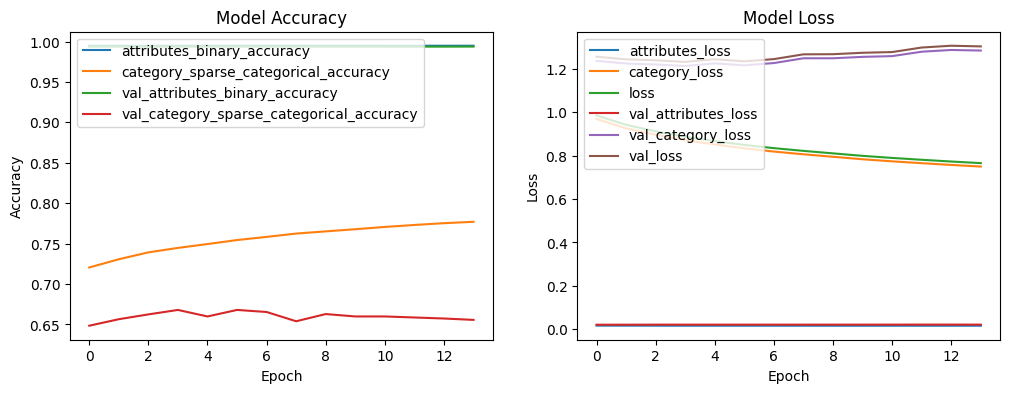

In [43]:
plot_history(history)

# Load best and Convert to tflite/onnx

In [ ]:
model_for_export = create_model(model_name="MobileNetV3Small", checkpointpath=CHECKPOINT_PATH, categories_num=NUM_CATEGORIES, attributes_num=NUM_ATTRIBUTES)

In [ ]:
# Export the model as a ONNX artifact
model_for_export.export(RUN_DIR, format="onnx")


In [ ]:

# Load the artifact in a different process/environment
# ort_session = onnxruntime.InferenceSession("path/to/location")
# ort_inputs = {
#     k.name: v for k, v in zip(ort_session.get_inputs(), input_data)
# }
# predictions = ort_session.run(None, ort_inputs)